## Preparing the environment

In [1]:
import os
import sys
import time
import random
import numpy as np

import torch
from torch.utils.data import DataLoader

from datasets import load_dataset, Dataset
import transformers
from peft import LoraConfig, get_peft_model, TaskType
from accelerate import Accelerator

from tqdm import tqdm

import matplotlib.pyplot as plt

sys.path.append("..")
from utils.relora import optimizer_reset, get_cosine_schedule_with_multiple_warmups


device = "cuda" if torch.cuda.is_available() else "cpu"

data_path = "../data"
models_path = "../models"

In [2]:
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = False

#### Setting constants

In [3]:
context_length = 128

batch_size = 128
num_workers = 8
global_batch_size = 512
accumulation_steps = global_batch_size // batch_size

learning_rate = 1e-3
betas = (0.9, 0.95)
eps = 1e-8
gradient_clipping = 1.0
weight_decay = 0.1

adjust_warmup_iters = 250  # from warm model
first_warmup_iters = 100
restart_warmup_iters = 50
min_lr_ratio = 0.001

adjust_train_iters = 500  # from warm model
train_iters = 2000  # train_iters including adjust_train_iters
eval_save_interval = 100
val_iters = 20

lora_rank = 128
lora_dropout = 0.1
lora_alpha = 32
relora_steps = 500
reset_optimizer_on_relora = False
optimizer_magnitude_pruning = 0.8

model_name = os.path.join(models_path, "pythia-70m_500_of_2000")
tokenizer_name = "EleutherAI/pythia-14m"
tokenizer_revision = "step1000"

dataset_path = "allenai/c4"
dataset_name = "realnewslike"

## Loading dataset

In [4]:
dataset = load_dataset(dataset_path, dataset_name)
dataset = dataset.with_format("torch")

Using the latest cached version of the dataset since allenai/c4 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'realnewslike' at /home/egor/.cache/huggingface/datasets/allenai___c4/realnewslike/0.0.0/1588ec454efa1a09f29cd18ddd04fe05fc8653a2 (last modified on Sun Jun  2 19:32:33 2024).


Loading dataset shards:   0%|          | 0/76 [00:00<?, ?it/s]

In [5]:
tokenizer = transformers.AutoTokenizer.from_pretrained(tokenizer_name, revision=tokenizer_revision)

def tokenize(data):
    outputs = tokenizer(
        data["text"],
        truncation=True,
        max_length=context_length,
        return_overflowing_tokens=True,
        return_length=True,
    )
    input_batch = list()
    # deleting samples shorter than context_length tokens
    for length, input_ids in zip(outputs["length"], outputs["input_ids"]):
        if length == context_length:
            input_batch.append(input_ids)
    return {"input_ids": input_batch}

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
if os.path.exists(os.path.join(data_path, "train_dataset")):
    train_dataset = Dataset.load_from_disk(os.path.join(data_path, "train_dataset"))
else:
    train_dataset = dataset["train"].map(
        tokenize, batched=True, remove_columns=dataset["train"].column_names
    )
    train_dataset.save_to_disk(os.path.join(data_path, "train_dataset"))


if os.path.exists(os.path.join(data_path, "val_dataset")):
    val_dataset = Dataset.load_from_disk(os.path.join(data_path, "val_dataset"))
else:
    val_dataset = dataset["validation"].map(
        tokenize, batched=True, remove_columns=dataset["validation"].column_names
    )
    val_dataset.save_to_disk(os.path.join(data_path, "val_dataset"))

Loading dataset from disk:   0%|          | 0/58 [00:00<?, ?it/s]

In [7]:
val_dataset = val_dataset.select(range(len(val_dataset) // (batch_size * val_iters) * (batch_size * val_iters)))

In [8]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

## Training

### ReLoRA Training

In [9]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed)

train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=num_workers,
                              worker_init_fn=seed_worker,
                              generator=g)
val_dataloader = DataLoader(val_dataset, 
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=num_workers,
                            worker_init_fn=seed_worker,
                            generator=g,
                            drop_last=True)

In [10]:
# sckipping adjested_iters
for i, _ in enumerate(train_dataloader):
    if i >= adjust_train_iters * accumulation_steps:
        break
for i, _ in enumerate(val_dataloader):
    if i >= adjust_train_iters * accumulation_steps:
        break

In [11]:
lora_config = LoraConfig(r=lora_rank, 
                         target_modules=["query_key_value", "dense",
                                         "dense_h_to_4h", "dense_4h_to_h"], 
                         lora_dropout=lora_dropout,
                         lora_alpha=lora_alpha)

# By default, PEFT initializes LoRA weights with Kaiming-uniform for weight A and zeros for weight B 
# resulting in an identity transform 

In [12]:
model = transformers.AutoModelForCausalLM.from_pretrained(model_name,
                                                          attn_implementation="flash_attention_2").to(device)

You are attempting to use Flash Attention 2.0 without specifying a torch dtype. This might lead to unexpected behaviour
You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.
Flash Attention 2.0 only supports torch.float16 and torch.bfloat16 dtypes, but the current dype in GPTNeoXForCausalLM is torch.float32. You should run training or inference using Automatic Mixed-Precision via the `with torch.autocast(device_type='torch_device'):` decorator, or load the model with the `torch_dtype` argument. Example: `model = AutoModel.from_pretrained("openai/whisper-tiny", attn_implementation="flash_attention_2", torch_dtype=torch.float16)`
Flash Attention 2.0 only supports torch.float16 and torch.bfloat16 dtypes, but the current dype in GPTNeoXModel is torch.float32. You should run training or inference using Automatic Mixed-Precision via the `with torch.autocast(device_type='torch

In [13]:
lora_model = get_peft_model(model, lora_config)
lora_model.print_trainable_parameters()

trainable params: 6,291,456 || all params: 76,718,080 || trainable%: 8.2007


In [14]:
for name, param in lora_model.named_parameters():
    if any([layer in name for layer in ["layernorm", "embed", "layer_norm"]]):
        param.requires_grad = True

In [15]:
lora_model.print_trainable_parameters()

trainable params: 57,816,064 || all params: 76,718,080 || trainable%: 75.3617


In [16]:
trainable_params = [p for p in lora_model.parameters() if p.requires_grad]
lora_params = [p for n, p in lora_model.named_parameters() if p.requires_grad and "lora_" in n]

In [17]:
optimizer = torch.optim.AdamW(trainable_params, lr=learning_rate, betas=betas, eps=eps, weight_decay=weight_decay)
optimizer_state_keys = ["exp_avg", "exp_avg_sq"]

scheduler = get_cosine_schedule_with_multiple_warmups(
    optimizer,
    num_training_steps=train_iters,
    first_warmup_steps=first_warmup_iters,
    restart_warmup_steps=restart_warmup_iters,
    restart_every=relora_steps,
    adjust_step=adjust_train_iters,
    adjust_warmup_iters=adjust_train_iters,
    min_lr_ratio=min_lr_ratio,
)

In [18]:
accelerator = Accelerator(mixed_precision="fp16")

lora_model, optimizer, train_dataloader, val_dataloader = accelerator.prepare(
    lora_model, optimizer, train_dataloader, val_dataloader
)

In [19]:
def evaluate(model, val_dataloader, val_iters):
    model.eval()
    val_losses = list()
    for step, batch in enumerate(val_dataloader):
        with torch.inference_mode():
            outputs = model(batch["input_ids"], labels=batch["input_ids"])
            val_losses.append(outputs.loss.item())
        if step + 1 >= val_iters:
            break
    val_loss = np.mean(val_losses)
    return val_loss

In [20]:
lora_model.train()

train_losses = dict()
val_losses = dict()
last_losses = list()
completed_steps = adjust_train_iters
n_lora_restarts = 0
n_optimizer_resets = 0

for step, batch in tqdm(
        enumerate(train_dataloader, start=1), total=int((train_iters - adjust_train_iters) * accumulation_steps)
    ):
    output = lora_model(batch["input_ids"], labels=batch["input_ids"])
    loss = output.loss
    last_losses.append(loss.item())
    loss /= accumulation_steps
    accelerator.backward(loss)

    if step % accumulation_steps == 0:
        accelerator.clip_grad_norm_(lora_model.parameters(), gradient_clipping)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        completed_steps += 1
    
    if step % (eval_save_interval * accumulation_steps) == 0:
        train_losses[completed_steps] = np.mean(last_losses)
        val_losses[completed_steps] = evaluate(lora_model, val_dataloader, val_iters)
        print(
            {
                "steps": completed_steps,
                "loss/train": train_losses[completed_steps],
                "loss/val": val_losses[completed_steps],
            }
        )
        last_losses = list()
        lora_model.train()
        accelerator.wait_for_everyone()
    
    if completed_steps >= train_iters:
        accelerator.wait_for_everyone()
        break

    if step % accumulation_steps != 0:
        continue

    can_reset_relora = relora_steps is not None and (completed_steps - adjust_train_iters) >= relora_steps

    if can_reset_relora and (completed_steps - adjust_train_iters) % relora_steps == 1:
        _lora_reset_time = time.time()
        print(f"Performing lora reset at update step {completed_steps}")
        n_lora_restarts += 1

        lora_model = lora_model.merge_and_unload()
        lora_model = get_peft_model(lora_model, lora_config)
        for name, param in lora_model.named_parameters():
            if any([layer in name for layer in ["layernorm", "embed", "layer_norm"]]):
                param.requires_grad = True

        trainable_params = [p for p in lora_model.parameters() if p.requires_grad]

        lora_model = accelerator.prepare(lora_model)
    
        optimizer.param_groups[0]['params'] = trainable_params

        _lora_reset_time = time.time() - _lora_reset_time
        print(f"LoRA reset took {_lora_reset_time:.2f}s")

        # scheduler should provide a new warmup after the reset
        print(f"Performing optimizer reset at update step {completed_steps}")
        n_optimizer_resets += 1

        optimizer_reset(
            optimizer,
            reset_params=lora_params,
            optimizer_state_keys=optimizer_state_keys,
            reset_optimizer_on_relora=reset_optimizer_on_relora,
            optimizer_random_pruning=0.0,
            optimizer_magnitude_pruning=optimizer_magnitude_pruning,
        )

  7%|▋         | 401/6000 [01:43<1:21:20,  1.15it/s]

{'steps': 600, 'loss/train': 4.44844859957695, 'loss/val': 4.417978191375733}


 13%|█▎        | 800/6000 [03:23<1:21:48,  1.06it/s]

{'steps': 700, 'loss/train': 4.408903977870941, 'loss/val': 4.405285048484802}


 20%|██        | 1201/6000 [05:03<51:48,  1.54it/s]  

{'steps': 800, 'loss/train': 4.375386879444123, 'loss/val': 4.336035966873169}


 27%|██▋       | 1601/6000 [06:36<42:23,  1.73it/s]

{'steps': 900, 'loss/train': 4.3542010831832885, 'loss/val': 4.3407920598983765}


 33%|███▎      | 2000/6000 [08:04<58:47,  1.13it/s]

{'steps': 1000, 'loss/train': 4.33266465306282, 'loss/val': 4.323440098762513}


 40%|████      | 2400/6000 [09:37<51:20,  1.17it/s]

{'steps': 1100, 'loss/train': 4.310643012523651, 'loss/val': 4.297901296615601}


 47%|████▋     | 2800/6000 [11:15<50:54,  1.05it/s]

{'steps': 1200, 'loss/train': 4.295683245658875, 'loss/val': 4.284490346908569}


 53%|█████▎    | 3200/6000 [12:53<43:20,  1.08it/s]

{'steps': 1300, 'loss/train': 4.274876056909561, 'loss/val': 4.275648999214172}


 60%|██████    | 3600/6000 [14:31<34:06,  1.17it/s]

{'steps': 1400, 'loss/train': 4.258704528808594, 'loss/val': 4.261094236373902}


 67%|██████▋   | 4000/6000 [16:09<30:59,  1.08it/s]

{'steps': 1500, 'loss/train': 4.248745279312134, 'loss/val': 4.246459746360779}


 73%|███████▎  | 4400/6000 [17:43<26:03,  1.02it/s]

{'steps': 1600, 'loss/train': 4.234857518672943, 'loss/val': 4.225220084190369}


 80%|████████  | 4801/6000 [19:16<13:13,  1.51it/s]

{'steps': 1700, 'loss/train': 4.226630371809006, 'loss/val': 4.206291151046753}


 87%|████████▋ | 5201/6000 [20:50<08:23,  1.59it/s]

{'steps': 1800, 'loss/train': 4.22549148440361, 'loss/val': 4.210065793991089}


 93%|█████████▎| 5601/6000 [22:24<03:54,  1.70it/s]

{'steps': 1900, 'loss/train': 4.217259511947632, 'loss/val': 4.207400894165039}


100%|█████████▉| 5999/6000 [23:58<00:00,  4.17it/s]

{'steps': 2000, 'loss/train': 4.213141443729401, 'loss/val': 4.215333962440491}


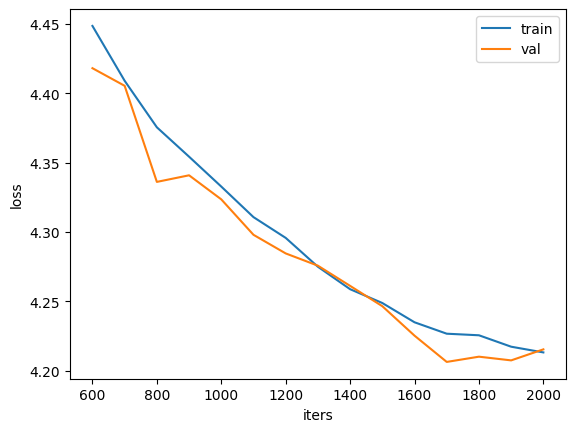

In [21]:
plt.plot(*zip(*train_losses.items()))
plt.plot(*zip(*val_losses.items()))
plt.legend(['train', 'val'], loc='upper right')
plt.ylabel('loss')
plt.xlabel('iters')
plt.show()

In [22]:
import json

with open(os.path.join("../plots/", model_name.split('/')[-1] + "_train_lora"), 'w') as fp:
    json.dump(train_losses, fp=fp)

with open(os.path.join("../plots/", model_name.split('/')[-1] + "_val_lora"), 'w') as fp:
    json.dump(train_losses, fp=fp)